<a href="https://colab.research.google.com/github/jpclima96/Kendrick-Data/blob/main/Kendrick_Lamar_Analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install spotipy


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


CLIENT_ID = '##########'
CLIENT_SECRET = '########'

In [32]:
client_credentials_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [33]:
def get_artist_id(spotify_url):
    """
    Extrai o ID do artista a partir da URL do Spotify
    """
    try:
        return spotify_url.split('/')[-1]
    except Exception as e:
        logger.error("Erro ao extrair ID do artista: %s", str(e))
        return None

In [34]:
def show_artist_related_artists(artist_id):
    """
    Mostra os artistas relacionados a um determinado artista
    """
    sp = get_spotify_client()
    if not sp:
        logger.error("Não foi possível conectar ao Spotify")
        return

    try:
        related = sp.artist_related_artists(artist_id)
        print("\nArtistas relacionados:")
        for artist in related['artists']:
            print(f"- {artist['name']}")
    except Exception as e:
        logger.error("Erro ao buscar artistas relacionados: %s", str(e))

In [35]:
def show_artist_info(artist_id):
    """
    Mostra informações detalhadas sobre o artista
    """
    sp = get_spotify_client()
    if not sp:
        return

    try:
        artist_info = sp.artist(artist_id)
        print("\nInformações do artista:")
        print(f"Nome: {artist_info['name']}")
        print(f"Gêneros: {', '.join(artist_info['genres'])}")
        print(f"Popularidade: {artist_info['popularity']}/100")
        print(f"Seguidores: {artist_info['followers']['total']:,}")

        # Buscando as top músicas do artista
        top_tracks = sp.artist_top_tracks(artist_id)
        print("\nTop 5 músicas:")
        for idx, track in enumerate(top_tracks['tracks'][:5], 1):
            print(f"{idx}. {track['name']}")

    except Exception as e:
        logger.error("Erro ao buscar informações do artista: %s", str(e))

In [36]:
kendrick = "https://open.spotify.com/artist/2YZyLoL8N0Wb9xBt1NhZWg"
artist_id = get_artist_id(kendrick)

In [37]:
if artist_id:
    print(f"ID do Kendrick Lamar: {artist_id}")
    show_artist_related_artists(artist_id)
    show_artist_info(artist_id)
else:
    logger.error("Não foi possível encontrar o artista: %s", kendrick)

ERROR:__main__:Não foi possível conectar ao Spotify


ID do Kendrick Lamar: 2YZyLoL8N0Wb9xBt1NhZWg


In [38]:
def get_all_albums(artist_id):
    albums = []
    results = sp.artist_albums(artist_id, album_type='album')

    while results:
        albums.extend(results['items'])
        if results['next']:
            results = sp.next(results)
        else:
            break

    # Removendo duplicatas (diferentes mercados/regiões)
    seen = set()
    unique_albums = []
    for album in albums:
        if album['name'].lower() not in seen:
            seen.add(album['name'].lower())
            unique_albums.append(album)

    return unique_albums

# Obtendo todos os álbuns
albums = get_all_albums(kendrick)

In [39]:
all_tracks = []

for album in albums:
    tracks = sp.album_tracks(album['id'])
    album_info = sp.album(album['id'])

    for track in tracks['items']:
        track_info = sp.track(track['id'])
        all_tracks.append({
            'album_name': album['name'],
            'album_release': album['release_date'],
            'track_name': track['name'],
            'duration_ms': track['duration_ms'],
            'popularity': track_info['popularity'],
            'track_id': track['id'],
            'album_popularity': album_info['popularity']
        })

df = pd.DataFrame(all_tracks)

## Musica mais popular

In [40]:
print("Música mais popular de Kendrick Lamar:")
most_popular = df.loc[df['popularity'].idxmax()]
print(f"'{most_popular['track_name']}' do álbum '{most_popular['album_name']}'")
print(f"Popularidade: {most_popular['popularity']}/100")

Música mais popular de Kendrick Lamar:
'tv off (feat. lefty gunplay)' do álbum 'GNX'
Popularidade: 92/100


## Música mais popular por álbum

In [41]:
print("\nMúsica mais popular de cada álbum:")
for album in df['album_name'].unique():
    album_df = df[df['album_name'] == album]
    most_popular = album_df.loc[album_df['popularity'].idxmax()]
    print(f"\n{album}:")
    print(f"- {most_popular['track_name']} (Popularidade: {most_popular['popularity']}/100)")


Música mais popular de cada álbum:

GNX:
- tv off (feat. lefty gunplay) (Popularidade: 92/100)

Mr. Morale & The Big Steppers:
- Count Me Out (Popularidade: 75/100)

Black Panther The Album Music From And Inspired By:
- All The Stars (with SZA) (Popularidade: 90/100)

DAMN. COLLECTORS EDITION.:
- PRIDE. (Popularidade: 51/100)

DAMN.:
- HUMBLE. (Popularidade: 85/100)

untitled unmastered.:
- untitled 08 | 09.06.2014. (Popularidade: 66/100)

To Pimp A Butterfly:
- Alright (Popularidade: 80/100)

good kid, m.A.A.d city (Deluxe):
- Poetic Justice (Popularidade: 72/100)

good kid, m.A.A.d city:
- Money Trees (Popularidade: 79/100)

Section.80:
- A.D.H.D (Popularidade: 72/100)

Overly Dedicated:
- Ignorance Is Bliss (Popularidade: 53/100)


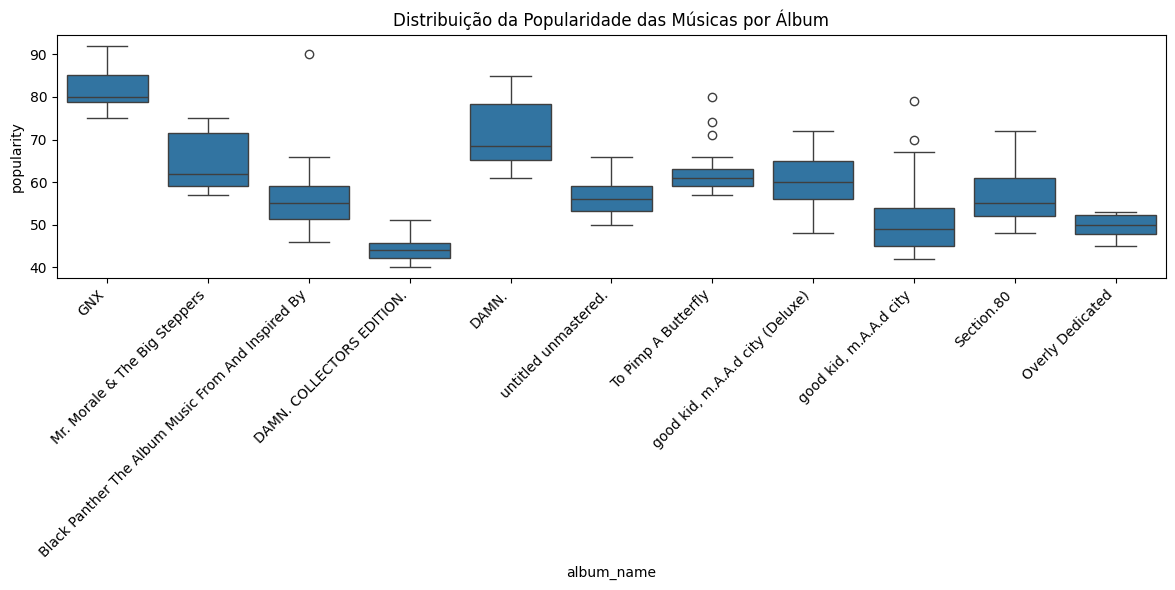

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='album_name', y='popularity')
plt.title('Distribuição da Popularidade das Músicas por Álbum')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##  Álbum mais popular

In [42]:
album_popularity = df.groupby('album_name')['album_popularity'].first()
most_popular_album = album_popularity.idxmax()
print(f"\nÁlbum mais popular: {most_popular_album}")
print(f"Popularidade: {album_popularity[most_popular_album]}/100")


Álbum mais popular: GNX
Popularidade: 91/100


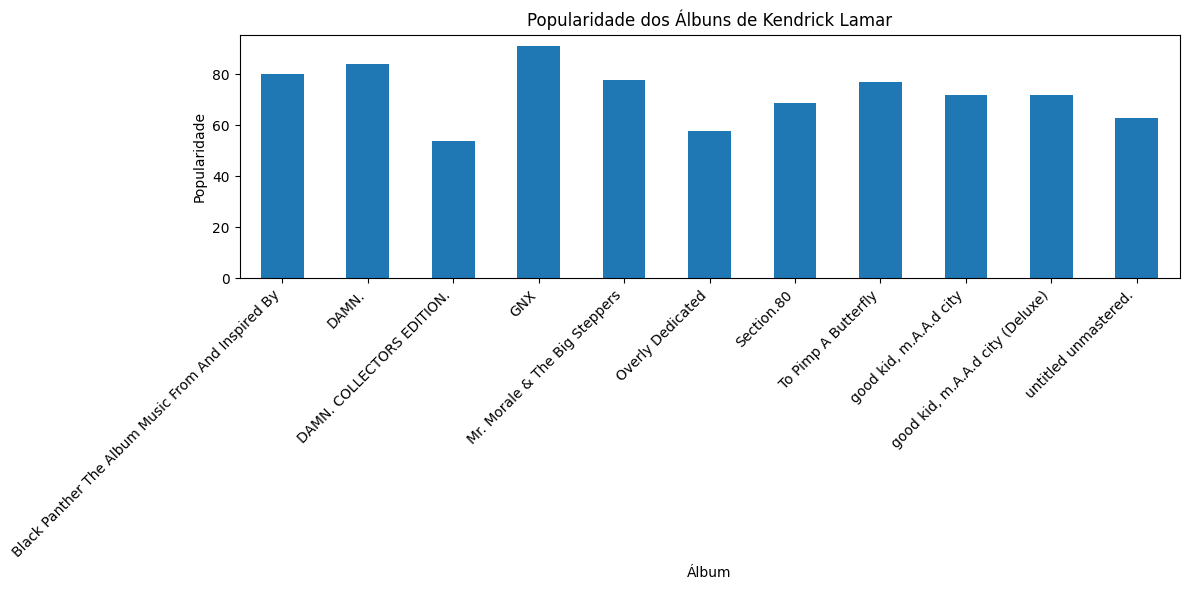

In [45]:
plt.figure(figsize=(12, 6))
album_popularity.plot(kind='bar')
plt.title('Popularidade dos Álbuns de Kendrick Lamar')
plt.xlabel('Álbum')
plt.ylabel('Popularidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Música mais longa

In [43]:
longest_track = df.loc[df['duration_ms'].idxmax()]
duration_min = longest_track['duration_ms'] / (1000 * 60)
print(f"\nMúsica mais longa: {longest_track['track_name']}")
print(f"Duração: {duration_min:.2f} minutos")


Música mais longa: Mortal Man
Duração: 12.12 minutos
